In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from pylab import rcParams
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm, tqdm_notebook

In [2]:
df = pd.read_csv('data/air_pollution.csv', parse_dates=['date'])
df.set_index('date', inplace=True)

In [3]:
split = '2014-01-01'
train = df.loc[df.index<=split]
test = df.loc[df.index>split]
print('train: %i' %len(train))
print('test: %i' %len(test))

train: 1461
test: 364


In [4]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

from sklearn.metrics import mean_squared_error


def rmse(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [5]:
# creating extra features
def generate_time_features(df, target=None):
  df['date'] = df.index
  df['hour'] = df['date'].dt.hour
  df['dayofweek'] = df['date'].dt.dayofweek
  df['quater'] = df['date'].dt.quarter
  df['month'] = df['date'].dt.month
  df['year'] = df['date'].dt.year
  df['dayofyear'] = df['date'].dt.dayofyear
  df['sin_day'] = np.sin(df['dayofyear'])
  df['cosday'] = np.cos(df['dayofyear'])
  df['dayofmonth'] = df['date'].dt.day
  df['weekofyear'] = df['date'].dt.weekofyear
  X = df.drop(['date'], axis=1)
  if target:
    y = df[target]
    X = X.drop([target], axis=1)
    return X, y

  return X

In [6]:
X_train, y_train = generate_time_features(train, target='pollution_today')
X_test, y_test = generate_time_features(test, target='pollution_today')

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [8]:
MAPE = {}
RMSE = {}
predictions = {}

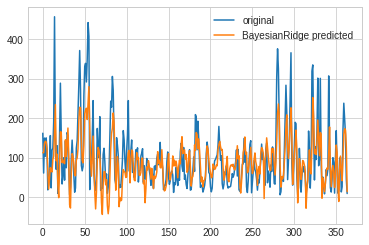

In [9]:
# bayesian regression
from sklearn import linear_model

breg = linear_model.BayesianRidge()
breg.fit(X_train, y_train)
yhat = breg.predict(X_test)

MAPE['BayesianRidge'] = mape(test.pollution_today, yhat)
RMSE['BayesianRidge'] = rmse(test.pollution_today, yhat)
predictions['BayesianRidge'] = yhat

plt.plot(test.pollution_today.values, label='original')
plt.plot(yhat, label='BayesianRidge predicted')
plt.legend(loc='best')

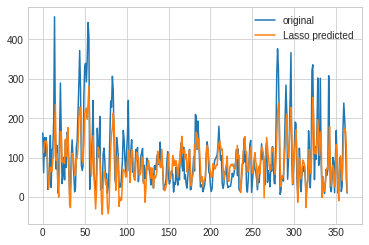

In [10]:
# Lasso regression

lasso = linear_model.Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
yhat = lasso.predict(X_test)

MAPE['Lasso'] = mape(test.pollution_today, yhat)
RMSE['Lasso'] = rmse(test.pollution_today, yhat)
predictions['Lasso'] = yhat

plt.plot(test.pollution_today.values, label='original')
plt.plot(yhat, label='Lasso predicted')
plt.legend(loc='best')

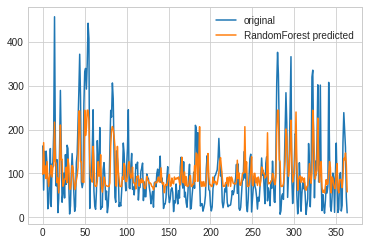

In [11]:
# RandomForest
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_depth=2, random_state=0)
rf.fit(X_train, y_train)
yhat = rf.predict(X_test)

MAPE['RandomForest'] = mape(test.pollution_today, yhat)
RMSE['RandomForest'] = rmse(test.pollution_today, yhat)
predictions['RandomForest'] = yhat

plt.plot(test.pollution_today.values, label='original')
plt.plot(yhat, label='RandomForest predicted')
plt.legend(loc='best')

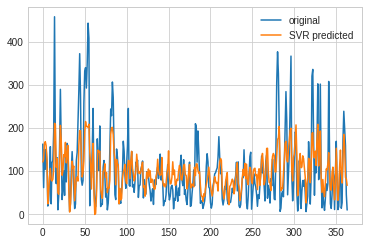

In [12]:
# SVM
from sklearn import svm

svr = svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
svr.fit(X_train, y_train)
yhat = svr.predict(X_test)

MAPE['SVR'] = mape(test.pollution_today, yhat)
RMSE['SVR'] = rmse(test.pollution_today, yhat)
predictions['SVR'] = yhat

plt.plot(test.pollution_today.values, label='original')
plt.plot(yhat, label='SVR predicted')
plt.legend(loc='best')

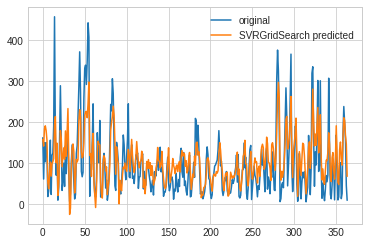

In [13]:
# GridSearch SVM
from sklearn.model_selection import GridSearchCV

svr = GridSearchCV(svm.SVR(kernel='rbf', gamma=0.1),
                   param_grid={'C':[1, 10, 100, 1000], 'gamma':np.logspace(-2,2,5)})
svr.fit(X_train, y_train)
yhat = svr.predict(X_test)

MAPE['SVRGridSearch'] = mape(test.pollution_today, yhat)
RMSE['SVRGridSearch'] = rmse(test.pollution_today, yhat)
predictions['SVRGridSearch'] = yhat

plt.plot(test.pollution_today.values, label='original')
plt.plot(yhat, label='SVRGridSearch predicted')
plt.legend(loc='best')

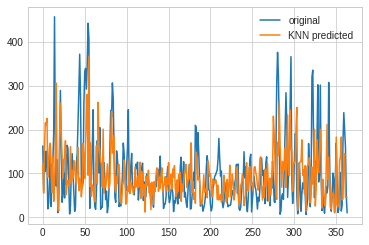

In [14]:
# kNN
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=2)
knn.fit(X_train, y_train)
yhat = knn.predict(X_test)

MAPE['KNN'] = mape(test.pollution_today, yhat)
RMSE['KNN'] = rmse(test.pollution_today, yhat)
predictions['KNN'] = yhat

plt.plot(test.pollution_today.values, label='original')
plt.plot(yhat, label='KNN predicted')
plt.legend(loc='best')

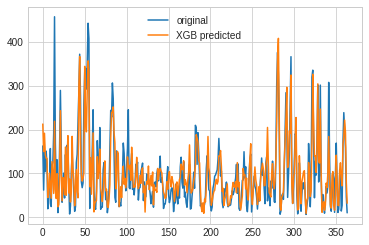

In [15]:
# XGBoost
import xgboost as xgb

XGB = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
XGB.fit(X_train, y_train)
yhat = XGB.predict(X_test)

MAPE['XGB'] = mape(test.pollution_today, yhat)
RMSE['XGB'] = rmse(test.pollution_today, yhat)
predictions['XGB'] = yhat

plt.plot(test.pollution_today.values, label='original')
plt.plot(yhat, label='XGB predicted')
plt.legend(loc='best')

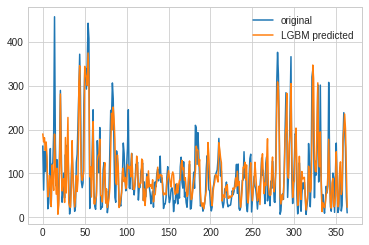

In [16]:
# lightgbm
import lightgbm as lgb

lgbm = lgb.LGBMRegressor()
lgbm.fit(X_train, y_train)
yhat = lgbm.predict(X_test)

MAPE['LGBM'] = mape(test.pollution_today, yhat)
RMSE['LGBM'] = rmse(test.pollution_today, yhat)
predictions['LGBM'] = yhat

plt.plot(test.pollution_today.values, label='original')
plt.plot(yhat, label='LGBM predicted')
plt.legend(loc='best')

In [17]:
# prophet
from fbprophet import Prophet

train_pr = train.rename(columns={'pollution_today':'y'})
train_pr['ds'] = train_pr.index
train_pr.index = pd.RangeIndex(len(train_pr.index))

test_pr = test.rename(columns={'pollution_today':'y'})
test_pr['ds'] = test_pr.index
test_pr.index = pd.RangeIndex(len(test_pr.index))

In [18]:
prophet = Prophet(growth='linear', seasonality_mode='multiplicative', daily_seasonality=True).add_country_holidays(country_name='China')

for col in train_pr.columns:
  if col not in ['ds','y']:
    prophet.add_regressor(col)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


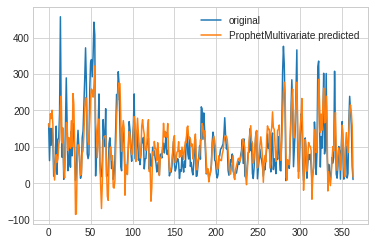

In [19]:
prophet.fit(train_pr)
yhat = prophet.predict(test_pr)

MAPE['ProphetMultivariate'] = mape(y_test, yhat.yhat.values)
RMSE['ProphetMultivariate'] = rmse(y_test, yhat.yhat.values)
predictions['ProphetMultivariate'] = yhat.yhat.values

plt.plot(test.pollution_today.values, label='original')
plt.plot(yhat.yhat.values, label='ProphetMultivariate predicted')
plt.legend(loc='best')

In [20]:
# LSTM

WINDOW_LENGTH = 24
BATCH_SIZE = 64
BUFFER_SIZE = 100

def window_data(X,Y,window=7):
  x = []
  y = []
  for i in range(window-1, len(X)):
    x.append(X[i-window+1:i+1])
    y.append(Y[i])
  return np.array(x), np.array(y)

X_n = np.concatenate((X_train, X_test))
y_n  = np.concatenate((y_train, y_test))

X_n, y_n = window_data(X_n, y_n, window=WINDOW_LENGTH)
X_train_n = X_n[:-len(X_test)]
X_test_n = X_n[-len(X_test):]
y_train_n = y_n[:-len(X_test)]
y_test_n = y_n[-len(X_test):]

print(f'Test sets are equal: {np.array_equal(y_test_n, y_test)}')

Test sets are equal: True


In [21]:
import tensorflow as tf

train_data = tf.data.Dataset.from_tensor_slices((X_train_n, y_train_n))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_data = tf.data.Dataset.from_tensor_slices((X_test_n, y_test_n))
test_data = test_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

In [22]:
lstm = tf.keras.models.Sequential([
                                   tf.keras.layers.LSTM(128, input_shape=X_train_n.shape[-2:], dropout=0.0),
                                   tf.keras.layers.Dense(128),
                                   tf.keras.layers.Dense(128),
                                   tf.keras.layers.Dense(1)
])

lstm.compile(optimizer='rmsprop', loss='mae')

In [23]:
lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               74752     
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 107,905
Trainable params: 107,905
Non-trainable params: 0
_________________________________________________________________


In [24]:
history = lstm.fit(train_data, epochs=10, steps_per_epoch=200, validation_data=test_data, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 12s 48ms/step - loss: 60.5453 - val_loss: 45.1728
Epoch 2/10
200/200 [==============================] - 9s 45ms/step - loss: 38.6604 - val_loss: 33.1102
Epoch 3/10
200/200 [==============================] - 9s 44ms/step - loss: 30.5310 - val_loss: 31.1470
Epoch 4/10
200/200 [==============================] - 9s 45ms/step - loss: 26.9275 - val_loss: 35.0452
Epoch 5/10
200/200 [==============================] - 9s 45ms/step - loss: 24.3737 - val_loss: 30.9899
Epoch 6/10
200/200 [==============================] - 9s 46ms/step - loss: 22.0896 - val_loss: 32.1853
Epoch 7/10
200/200 [==============================] - 9s 45ms/step - loss: 19.9774 - val_loss: 30.6430
Epoch 8/10
200/200 [==============================] - 9s 44ms/step - loss: 18.0613 - val_loss: 32.4716
Epoch 9/10
200/200 [==============================] - 9s 43ms/step - loss: 16.2586 - val_loss: 34.2792
Epoch 10/10
200/200 [==============================] - 9s 45ms/step - lo

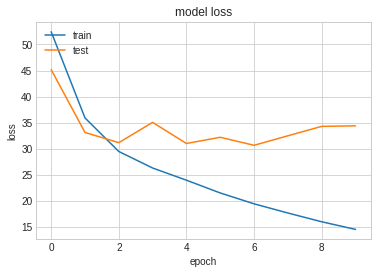

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

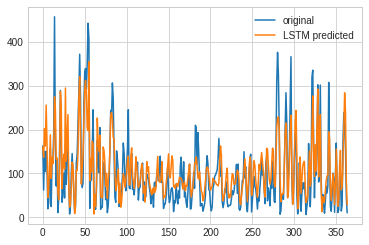

In [29]:
yhat = lstm.predict(X_test_n).reshape(1,-1)[0]

MAPE['LSTM'] = mape(y_test, yhat)
RMSE['LSTM'] = rmse(y_test, yhat)
predictions['LSTM'] = yhat

plt.plot(test.pollution_today.values, label='original')
plt.plot(yhat, label='LSTM predicted')
plt.legend(loc='best')

In [30]:
RMSE_df = pd.DataFrame(RMSE, index=[0])
RMSE_df = RMSE_df.T
RMSE_df.columns = ['RMSE']
RMSE_df = RMSE_df.sort_values(by=['RMSE'])
RMSE_df

,RMSE
LGBM,42.745285
XGB,43.195546
LSTM,45.891005
SVRGridSearch,50.340027
ProphetMultivariate,51.016060
Lasso,54.583998
BayesianRidge,54.634477
SVR,56.032800
RandomForest,59.448943
KNN,80.387336


In [31]:
MAPE_df = pd.DataFrame(MAPE, index=[0])
MAPE_df = MAPE_df.T
MAPE_df.columns = ['MAPE']
MAPE_df = MAPE_df.sort_values(by=['MAPE'])
MAPE_df

,MAPE
LGBM,52.233762
XGB,54.214471
LSTM,64.259572
BayesianRidge,70.787398
Lasso,70.903118
ProphetMultivariate,77.415609
SVRGridSearch,77.677857
SVR,79.422351
RandomForest,102.927586
KNN,108.293650


In [33]:
# ensembling
models = ['LGBM', 'XGB', 'LSTM']
resids = pd.DataFrame(data={k: test.pollution_today.values-v for k,v in predictions.items()})[models]
corr = resids.corr()
print('Correlation between residuals')
corr.style.background_gradient(cmap='viridis')

Correlation between residuals


,LGBM,XGB,LSTM
LGBM,1.000000,0.879884,0.637384
XGB,0.879884,1.000000,0.572619
LSTM,0.637384,0.572619,1.000000


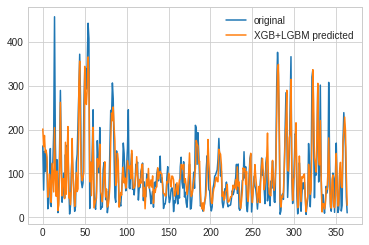

In [34]:
predictions['XGB+LGBM'] = (predictions['XGB']+predictions['LGBM'])/2
MAPE['XGB+LGBM'] = mape(test.pollution_today.values, predictions['XGB+LGBM'])
RMSE['XGB+LGBM'] = rmse(test.pollution_today.values, predictions['XGB+LGBM'])

plt.plot(test.pollution_today.values, label='original')
plt.plot(predictions['XGB+LGBM'], label='XGB+LGBM predicted')
plt.legend(loc='best')

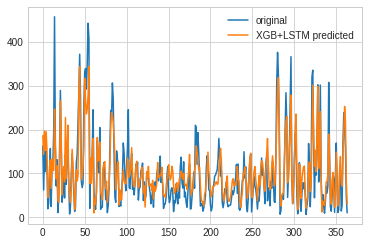

In [35]:
predictions['XGB+LSTM'] = (predictions['XGB']+predictions['LSTM'])/2
MAPE['XGB+LSTM'] = mape(test.pollution_today.values, predictions['XGB+LSTM'])
RMSE['XGB+LSTM'] = rmse(test.pollution_today.values, predictions['XGB+LSTM'])

plt.plot(test.pollution_today.values, label='original')
plt.plot(predictions['XGB+LSTM'], label='XGB+LSTM predicted')
plt.legend(loc='best')

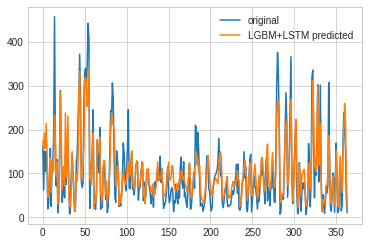

In [36]:
predictions['LGBM+LSTM'] = (predictions['LGBM']+predictions['LSTM'])/2
MAPE['LGBM+LSTM'] = mape(test.pollution_today.values, predictions['LGBM+LSTM'])
RMSE['LGBM+LSTM'] = rmse(test.pollution_today.values, predictions['LGBM+LSTM'])

plt.plot(test.pollution_today.values, label='original')
plt.plot(predictions['LGBM+LSTM'], label='LGBM+LSTM predicted')
plt.legend(loc='best')

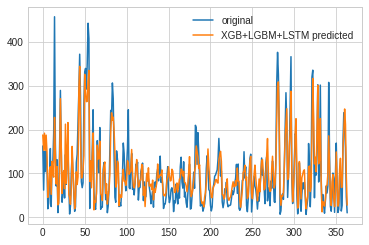

In [37]:
predictions['XGB+LGBM+LSTM'] = (predictions['XGB']+predictions['LGBM']+predictions['LSTM'])/3
MAPE['XGB+LGBM+LSTM'] = mape(test.pollution_today.values, predictions['XGB+LGBM+LSTM'])
RMSE['XGB+LGBM+LSTM'] = rmse(test.pollution_today.values, predictions['XGB+LGBM+LSTM'])

plt.plot(test.pollution_today.values, label='original')
plt.plot(predictions['XGB+LGBM+LSTM'], label='XGB+LGBM+LSTM predicted')
plt.legend(loc='best')

In [38]:
RMSE_df = pd.DataFrame(RMSE, index=[0])
RMSE_df = RMSE_df.T
RMSE_df.columns = ['RMSE']
RMSE_df = RMSE_df.sort_values(by=['RMSE'])
RMSE_df

,RMSE
XGB+LGBM+LSTM,39.068575
XGB+LSTM,39.380731
LGBM+LSTM,39.970314
XGB+LGBM,41.660260
LGBM,42.745285
XGB,43.195546
LSTM,45.891005
SVRGridSearch,50.340027
ProphetMultivariate,51.016060
Lasso,54.583998


In [39]:
MAPE_df = pd.DataFrame(MAPE, index=[0])
MAPE_df = MAPE_df.T
MAPE_df.columns = ['MAPE']
MAPE_df = MAPE_df.sort_values(by=['MAPE'])
MAPE_df

,MAPE
XGB+LGBM,52.018048
LGBM,52.233762
XGB+LGBM+LSTM,53.148997
XGB,54.214471
LGBM+LSTM,55.058945
XGB+LSTM,55.417591
LSTM,64.259572
BayesianRidge,70.787398
Lasso,70.903118
ProphetMultivariate,77.415609
